# PCB Defect Image Extraction

### Install tetryonai

In [0]:
!pip install git+https://github.com/sean-mcclure/tetryon_ai.git

In [0]:
from tetryonai.main import *

###Make the following folders:

*   difference_img
*   extracted_defects

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "difference_img"
})

directory(**{
    "choice" : "make",
    "directory_path" : "extracted_defects"
})

###Clone PCB Dataset

In [3]:
!git clone https://github.com/tangsanli5201/DeepPCB.git

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 38.49 MiB/s, done.
Resolving deltas: 100% (191/191), done.


### Read in PCB Defect Images (temp and test)

In [0]:
import glob

image_path = 'DeepPCB/PCBData/'
temp_pattern = '/*temp.jpg'
test_pattern = '/*test.jpg'

temps_and_tests = {}

for folder in os.listdir(image_path):
    full_path = image_path + folder + '/' + folder.replace('group', '')
    temps = glob.glob(full_path + '/' + temp_pattern)
    tests = glob.glob(full_path + '/' + test_pattern)
    inner = {}
    inner['temps'] = temps
    inner['tests'] = tests
    temps_and_tests[folder] = inner

### Difference all PCB images

In [0]:
for index, whatever in enumerate(temps_and_tests['group00041']['temps']):
    root_img_name = temps_and_tests['group00041']['temps'][index].replace('_temp.jpg', '')
    temp_file_path = root_img_name  + '_temp.jpg'
    test_file_path = root_img_name + '_test.jpg'

    subtract_images(**{
        "image_path_1" : temp_file_path,
        "image_path_2" : test_file_path,
        "write_path" : "difference_img/diff_image_" + str(index) + ".png"
    })

### Extract the defects from all differenced images

In [0]:
all_differenced_images = os.listdir('difference_img')

In [0]:
for index, filename in enumerate(all_differenced_images):
    os.mkdir("extracted_defects/extracts_" + str(index))
    this_write_path = "extracted_defects/extracts_" + str(index) + "/"
    extract_contours_from_image(**{
        "image_path" : "difference_img/" + filename,
        "write_path" : this_write_path,
        "hsv_lower" : [0,150,50],
        "hsv_upper" : [10,255,255]
    })

### Combine extracted images into single directory

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "all_extracts"
})

In [0]:
cnt=0
for dirpath, dirs, files in os.walk("extracted_defects"):
    for index, filename in enumerate(files):
        if filename.endswith(".png"):
            cnt += 1            
            move_files(**{
                "file_paths" : [dirpath + "/" + filename],
                "target_directory" : "all_extracts/extract_" + str(cnt) + ".png"
            })

### Zip all extracted defect images

In [0]:
!zip -r /content/extracted_defects.zip /content/all_extracts/

### Create JSON file for defect turker

In [0]:
import json

file_names_and_sizes = {}
file_names = os.listdir('all_extracts/')

for index, file in enumerate(file_names):
  file_names_and_sizes[file_names[index]] = os.path.getsize('all_extracts/' + file)

### Remove any image paths with sizes 0
#### Already taken care of by using tetryonai's contour function, but keeping here for others to use if needed

In [0]:
file_names_and_sizes = {k: v for k, v in file_names_and_sizes.items() if v != 0}

### Save JSON to Disk for Uploading to Defect Turker

In [0]:
with open('extracted_defects.json', 'w') as outfile:
    json.dump(file_names_and_sizes, outfile)

# PCB Defect Classification

##Install FASTAI

In [0]:
!pip install http://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install fastai

In [0]:
from fastai.vision import *

### Upload labelled data (CSV file)

In [19]:
from google.colab import files
files.upload()

Saving image_labels.csv to image_labels.csv


{'image_labels.csv': b'name,label\r\nname,label\r\nname,label\r\nextract_1158.png,NOT\r\nextract_1580.png,spur\r\nextract_1555.png,spur\r\nextract_866.png,spur\r\nextract_688.png,spur\r\nextract_15.png,NOT\r\nextract_622.png,spur\r\nextract_410.png,spur\r\nextract_338.png,spur\r\nextract_1141.png,short\r\nextract_1439.png,NOT\r\nextract_1205.png,NOT\r\nextract_590.png,spurious copper\r\nextract_575.png,short\r\nextract_703.png,spur\r\nextract_478.png,NOT\r\nextract_1250.png,spur\r\nextract_582.png,NOT\r\nextract_1428.png,spurious copper\r\nextract_678.png,NOT\r\nextract_1583.png,NOT\r\nextract_700.png,NOT\r\nextract_864.png,spur\r\nextract_1160.png,NOT\r\nextract_30.png,short\r\nextract_50.png,short\r\nextract_1340.png,NOT\r\nextract_996.png,NOT\r\nextract_1214.png,spur\r\nextract_482.png,spur\r\nextract_1497.png,NOT\r\nextract_1324.png,spurious copper\r\nextract_1284.png,spurious copper\r\nextract_695.png,spurious copper\r\nextract_1473.png,NOT\r\nextract_328.png,NOT\r\nextract_159.pn

### Convert labelled data CSVt to dataframe

In [0]:
image_labels_frame = csv_to_dataframe(**{
    "path_to_csv" : "image_labels.csv"
})

### Check Class Balance

In [0]:
labelled_counts = get_feature_counts(**{
    "data_frame" : image_labels_frame, 
    "feature" : "label"
})

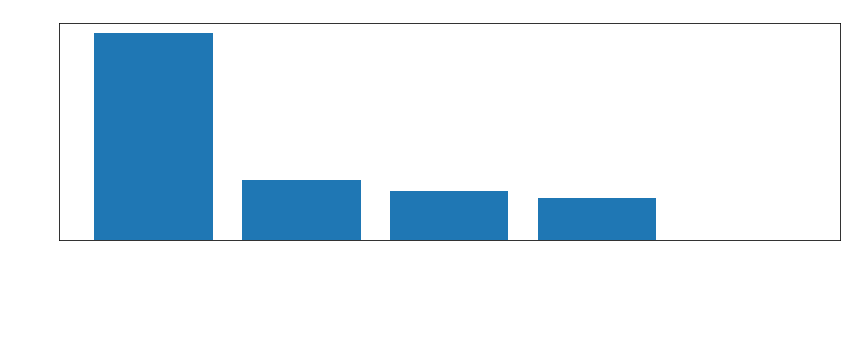

In [22]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 4
rcParams['text.color'] = "white"
rcParams['axes.labelcolor'] = "white"
rcParams['xtick.color'] = "white"
rcParams['ytick.color'] = "white"

index = np.arange(len(labelled_counts.keys()))
plt.bar(index, list(labelled_counts.values()))
plt.xlabel('Defect Type', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, labelled_counts.keys(), fontsize=5, rotation=30)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Defect Class Balance')
plt.show()

### Create new directory for training CSVs

In [0]:
directory(**{
    "choice" : "make",
    "directory_path" : "training_csvs"
})

### Create individual CSV files for each CLASS

In [0]:
spur = []
short = []
spurious = []
not_defect = []
for index, row in image_labels_frame.iterrows():
  if(row[1] == 'spur'):
    spur.append(row[0])
  if(row[1] == 'short'):
    short.append(row[0])
  if(row[1] == 'spurious copper'):
    spurious.append(row[0])
  if(row[1] == 'NOT'):
    not_defect.append(row[0])

In [0]:
df_spur = pd.DataFrame(spur)
df_spur.to_csv("spur.csv", sep=',',index=False)

df_short = pd.DataFrame(short)
df_short.to_csv("short.csv", sep=',',index=False)

df_spurious = pd.DataFrame(spurious)
df_spurious.to_csv("spurious.csv", sep=',',index=False)

df_not_defect = pd.DataFrame(not_defect)
df_not_defect.to_csv("not_defect.csv", sep=',',index=False)

### Create Directories for CSV files (needed for FastAI)

In [0]:
for folder in ['short', 'spur', 'spurious', 'not_defect']:
    directory(**{
        "choice" : "make",
        "directory_path" : "training_csvs/" + folder
    })

### Move CSV files to all_extracts directory

In [0]:
move_files(**{
    "file_paths" : ["short.csv", "spur.csv", "spurious.csv", "not_defect.csv"],
    "target_directory" : "training_csvs/"
})

### Move extracted defect images into respective folders based on labels in CSV files
#### Be sure to use the same image folder that was used to for Defect Turking. If you've restarted/rerun this pipeline since turking, upload the older image ZIP file (see Medium article for details)

In [0]:
# if needed
files.upload()

In [0]:
# if needed
move_files(**{
    "file_paths" : ["defect_images_or.zip"],
    "target_directory" : "training_csvs"
})

In [0]:
# if needed
import zipfile
with zipfile.ZipFile("training_csvs/defect_images_or.zip", 'r') as zip_ref:
    zip_ref.extractall("training_csvs/")

In [0]:
path = "training_csvs/"

for index, row in df_spur.iterrows():    
    from_path = path + row[0]
    to_path = path + "/spur/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })
    
for index, row in df_short.iterrows():    
    from_path = path + row[0]
    to_path = path + "/short/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })
    
for index, row in df_spurious.iterrows():    
    from_path = path + row[0]
    to_path = path + "/spurious/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

for index, row in df_not_defect.iterrows():    
    from_path = path + row[0]
    to_path = path + "/not_defect/" + row[0]
    move_files(**{
        "file_paths" : [from_path],
        "target_directory" : to_path
    })

In [0]:
# remove any PNG files not labelled 
for item in os.listdir('training_csvs/'):
    if item.endswith(".png"):
        os.remove(os.path.join('training_csvs/', item))

### Read in image data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4, bs=10).normalize(imagenet_stats)

### Inspect Images to Confirm Read Properly

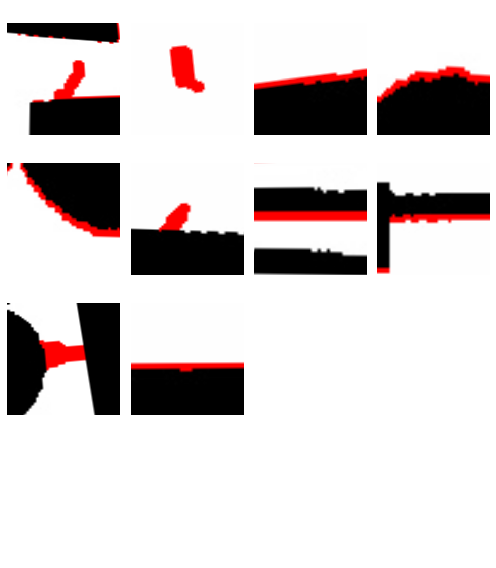

In [48]:
data.show_batch(rows=4, figsize=(7, 8))

### Train Model

In [49]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 54400564.23it/s]


### Use fit_one_cycle to change the learning rate over time (use GPU)

In [50]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.095103,0.446376,0.128713,04:17
1,0.707020,0.294207,0.108911,04:12
2,0.528814,0.232911,0.089109,04:13
3,0.399699,0.212845,0.079208,04:12
4,0.374707,0.191185,0.074257,04:12
5,0.338945,0.140814,0.044554,04:09
6,0.300264,0.140626,0.064356,04:11
7,0.246102,0.161271,0.049505,04:11
8,0.271339,0.129381,0.049505,04:12
9,0.209971,0.129171,0.054455,04:10


### Find better learning rates using lr_find, and use recorder.plot to create a plot that relates the learning rate with the loss.

In [58]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


### Train the model using differential learning rates by passing the max_lr argument to the fit_one_cycle method.

In [60]:
learn.fit_one_cycle(4, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.323528,0.105361,0.054455,06:12
1,0.290350,0.064906,0.014851,06:04
2,0.191790,0.046826,0.019802,06:02
3,0.131582,0.034415,0.004950,06:01


### SAVE the model for inference

In [0]:
learn.save('defect_classifier')

### Export Model

In [0]:
learn.load('defect_classifier')
learn.export('defect_classifier.pkl')

### Examine Confusion Matrix

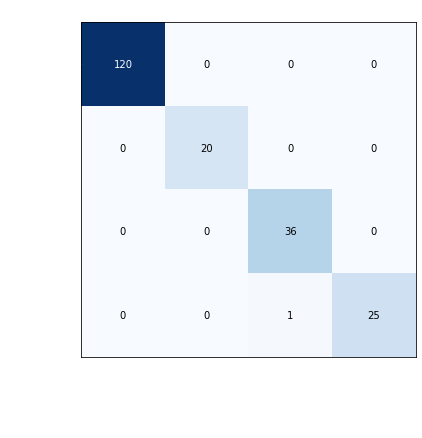

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

### Zip another folder from PCB Dataset for use in Application Testing

In [0]:
zip_files_in_directory(**{
    "directory" : "DeepPCB/PCBData/group12000/12000/",
    "zip_filename" : "test_temp_for_app.zip"
})